# Example 7a: Using the Time to First Detection (TTFD) Plot Type To Assess Plume Migration and Monitoring Network Performance in a Script Application of NRAP-Open-IAM.

This example demonstrates how to use the TTFD plot type in a .py script. The figures and .csv files produced show how TDS plumes (areas with a relative change in TDS of > 10 %) change in time in an aquifer. If monitoring well locations are provided, the figures and .csv files also show the times at which the monitoring wells could detect the plumes.

The TTFD plot type is run after the simulation has been completed. In order to use the plot type, one must set up the system model to include certain components and certain component outputs. For example, the system model must have an aquifer component that produces plume size metrics corresponding with the type of plume being assessed (e.g., TDS_dx, TDS_dy, TDS_dz outputs for TTFD plots examining TDS plumes in the aquifer).

First, we import the required libraries. Note that before this example can be run, one need to have the OpenIAMEnv environment activated (environment containing the python libraries required to run NRAP-Open-IAM - see the installation .txt files in the 'installers' folder). For example, one can open Anaconda Prompt, use the command "conda activate OpenIAMEnv" to activate the environment, navigate to the directory for NRAP-Open-IAM, and then use the command "jupyter notebook" to open Jupyter Notebook from that directory and within that environment. Then, the jupyter notebook examples will have access to the Python libraries within NRAP-Open-IAM environment.

Note that the code in this example should be run in order (from the top of this page to the bottom). Doing otherwise will result in errors, as the variables defined in previous steps will be considered missing.

In [1]:
import sys
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from openiam.components.iam_base_classes import IAM_DIR, SystemModel
from openiam.components.stratigraphy_component import Stratigraphy
from openiam.components.analytical_reservoir_component import AnalyticalReservoir
from openiam.components.multisegmented_wellbore_component import MultisegmentedWellbore
from openiam.components.rate_to_mass_adapter import RateToMassAdapter
from openiam.components.futuregen2_aquifer_component import FutureGen2Aquifer
from openiam.components.futuregen2_azmi_component import FutureGen2AZMI

import openiam.visualization as iam_vis

Here, we define variables that impact the formatting of matplotlib figures. It is more convenient to define such variables in one place rather than changing them in multiple locations throughout the code.

In [2]:
# Change the default formatting of matplotlib figures
%matplotlib inline

genfontsize = 8
axislabelfontsize = 10
titlefontsize = 10

RC_FONT = {'family': 'Arial', 'weight': 'normal', 'size': genfontsize}

figsize1 = (8, 8)
figsize2 = (12, 10)

# The dots-per-inch (dpi) used for figures
dpiRef = 100

# Extension used when saving figures
extension = '.png'

Next, define key inputs for the simulation. These inputs include the number of years to assess (num_years) and the site's stratigraphy. By defining the unit thicknesses here, you do not have to change the values in multiple locations further below (but you do need to rerun each section if you change these values).

Additionally, the aqRef variable controls whether the TTFD analysis focuses on aquifer 1 (aqRef = 0) or aquifer 2 (aqRef = 1). The upper limits for the x and y values of randomly generated wells are controlled by max_x_value and max_y_value (in meters), respectively.

In [3]:
# Define keyword arguments of the system model
num_years = 50
time_array = 365.25 * np.arange(0.0, num_years + 1)
sm_model_kwargs = {'time_array': time_array}   # time is given in days

# Information for the stratigraphy component. Thicknesses are in meters.
# Note that the depth of aquifer 1 specifies whether the aquifer component
# used will be a FutureGen2Aquifer (bottom depth from 100 m to 700 m) or 
# FutureGen2AZMI (bottom depth from 700 m to 1600 m).
datumPressure = 101325     # in Pa

numberOfShaleLayers = 3
                           # parameter ranges allowed:
shale1Thickness = 650      # shale Thickness: min: 1, max: 1600, default: 250
shale2Thickness = 450
shale3Thickness = 250
aquifer1Thickness = 90     # The aquifer thickness range allowed by the FutureGen2Aquifer
aquifer2Thickness = 80     # and FutureGen2AZMI components is 10 m to 90 m
reservoirThickness = 75    # resevoir Thickness: min: 1, max: 1600, default: 50

shaleThicknesses = [shale1Thickness, shale2Thickness, shale3Thickness]
aquiferThicknesses = [aquifer1Thickness, aquifer2Thickness]

num_aquifers = len(aquiferThicknesses)

aquiferTopDepths = [shaleThicknesses[1] + shaleThicknesses[2] + aquifer2Thickness,     # aquifer 1
                    shaleThicknesses[2]]                                               # aquifer 2

aquiferBottomDepths = [aquiferTopDepths[0] + aquifer1Thickness,                        # aquifer 1
                       aquiferTopDepths[1] + aquifer2Thickness]                        # aquifer 2

# This variable controls which aquifer you are evaluating in the TTFD plot. 
# For aquifer 1: aqRef = 0. For aquifer 2: aqRef = 1.
aqRef = 0

# The randomly generated wells' x- and y- coordinates will between 0 and these maxima.
max_x_value = 5000
max_y_value = 5000

# Injection site location in easting (x) and northing (y) distances (in meters)
injectionX = 2500
injectionY = 2500

Now, set up the dictionaries model_data and yaml_data. These dictionaries are required by the TTFD plot type.

All of the options entered under the if statement 'if use_specific_settings:' are optional; the TTFD plot type will run even if those entries are not provided.

If you want to let the TTFD plot type resort to default settings, try setting use_specific_settings to False. If use_specific_settings is set to False, no monitoring wells will be used in the TTFD plots - it will only show the evolution of the plumes, not when the plumes can be detected.

In [4]:
# Set up the dictionaries required by ttfd_plot()
model_data = dict()
model_data['OutputDirectory'] = os.path.join(
    IAM_DIR, 'output', 'Jupyter_Notebook_ttfdplot_example_'
    + str(datetime.date.today()))

yaml_data = dict()
yaml_data['Stratigraphy'] = {
    'shale1Thickness': shale1Thickness,
    'shale2Thickness': shale2Thickness,
    'shale3Thickness': shale3Thickness,
    'aquifer1Thickness': aquifer1Thickness,
    'aquifer2Thickness': aquifer2Thickness,
    'reservoirThickness': reservoirThickness}

# The name entered for the TTFD plot does not matter. The figures made will 
# have the same extension used here (e.g., .png or .tiff), however.
plotName = 'Plot1' + extension
yaml_data['Plots'] = dict()
yaml_data['Plots'][plotName] = dict()
yaml_data['Plots'][plotName]['TTFD'] = dict()

# These entries are required
yaml_data['Plots'][plotName]['TTFD']['PlumeType'] = 'TDS'
yaml_data['Plots'][plotName]['TTFD']['ComponentNameList'] = ['FutureGen2AZMI1']

use_specific_settings = True
# The remaining options are not required. Try
# setting use_specific_settings to False.
if use_specific_settings:
    yaml_data['Plots'][plotName]['TTFD']['PlotInjectionSites'] = True
    yaml_data['Plots'][plotName]['TTFD']['WriteDreamOutput'] = False
    
    # These are the x and y distances (m) between the injection site and the four
    # monitoring wells. The wells are arranged in a square around the injection site.
    wellXSpacing = 1000
    wellYSpacing = 1000
    
    # x and y coordinates for the monitoring wells.
    monitor_coordx = [injectionX - wellXSpacing, injectionX + wellXSpacing, 
                     injectionX + wellXSpacing, injectionX - wellXSpacing]
    monitor_coordy = [injectionY - wellXSpacing, injectionY - wellYSpacing, 
                     injectionY + wellXSpacing, injectionY + wellYSpacing]
    
    # These are the horizontal and vertical distances (m) from the monitoring well locations 
    # (x, y, z) within which plumes will be detected. If you want to make the sensors extend over 
    # a longer portion of the well, increase vertical_window.
    horizontal_window = 1
    vertical_window = 5

    # z coordinates (depths) for the monitoring well's sensors. These are near the top of the aquifer 
    # being assessed (controlled by the aqRef variable) and extending up and down by the vertical_window 
    # distance. You can try changing the depths from 
    # (-aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.25)) to 
    # (-aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.75)) to use depths near the bottom 
    # of the unit. Note that these depths need to be negative.
    monitor_coordz = [-aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.25),
                      -aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.25),
                      -aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.25),
                      -aquiferTopDepths[aqRef] - (aquiferThicknesses[aqRef] * 0.25)]
    
    yaml_data['Plots'][plotName]['TTFD']['MonitoringLocations'] = {
        'coordx': monitor_coordx, 'coordy': monitor_coordy, 'coordz': monitor_coordz,
        'HorizontalWindow': horizontal_window, 'VerticalWindow': vertical_window}
    
    yaml_data['Plots'][plotName]['TTFD']['FigureDPI'] = dpiRef
    
    yaml_data['Plots'][plotName]['TTFD']['FigureSize'] = figsize2
    
    # Specifies whether to save .csv files of plume timings and TTFD from monitoring wells
    yaml_data['Plots'][plotName]['TTFD']['SaveCSVFiles'] = True
    
    yaml_data['Plots'][plotName]['TTFD']['SpecifyXandYLims'] = {
        'xLims': [-100, max_x_value + 100],
        'yLims': [-100, max_y_value + 100]}
    
    yaml_data['Plots'][plotName]['TTFD']['SpecifyXandYGridLims'] = {
        'gridXLims': [0, max_x_value], 'gridYLims': [0, max_y_value]}

Now, create the system model object and the stratigraphy component. The unit thicknesses for the stratigraphy component are defined further above so that you do not have to change them in multiple locations every time they are updated.

In [5]:
# Create system model
sm = SystemModel(model_kwargs = sm_model_kwargs)

# Add stratigraphy component for the reference point
strata = sm.add_component_model_object(Stratigraphy(
    name='strata', parent=sm))

# Add parameters for the stratrigraphy component
strata.add_par('numberOfShaleLayers', value=numberOfShaleLayers, vary=False)
strata.add_par('shale1Thickness', value=shale1Thickness, vary=False)
strata.add_par('shale2Thickness', value=shale2Thickness, vary=False)
strata.add_par('shale3Thickness', value=shale3Thickness, vary=False)
strata.add_par('aquifer1Thickness', value=aquifer1Thickness, vary=False)
strata.add_par('aquifer2Thickness', value=aquifer2Thickness, vary=False)
strata.add_par('reservoirThickness', value=reservoirThickness, vary=False)
strata.add_par('datumPressure', value=datumPressure, vary=False)

# The get_composite_depth_names() method provides a list of all of the 
# depth names that are calculated as composite parameters (e.g., shale1Depth', 
# 'aquifer1MidDepth', 'shale2TopDepth', etc.)
composite_depth_pars = strata.get_composite_depth_names()

for comp_depth in composite_depth_pars:
        # The method get_depth_expr() provides the expression string needed to 
        # calculate a unit depth as a composite parameter (e.g., aquifer2MidDepth
        # calculated as 'strata.shale3Thickness + (strata.aquifer2Thickness / 2)').
        par_expr = strata.get_depth_expr(comp_depth)
        strata.add_composite_par(comp_depth, par_expr)

This example uses randomly generated well locations. If you rerun the section below, it will regenerate the x and y values for the wells.

In [6]:
numberOfWells = 5

np.random.seed(random.randint(0, 1.0e6))

well_x_values = np.random.rand(1, numberOfWells) * max_x_value
well_x_values = well_x_values.tolist()[0]

well_y_values = np.random.rand(1, numberOfWells) * max_y_value
well_y_values = well_y_values.tolist()[0]

print('(x, y) values, in meters:')
for locRef in range(numberOfWells):
    print('Well {}: ({:.2f}, {:.2f})'.format(
    locRef, well_x_values[locRef], well_y_values[locRef]))

(x, y) values, in meters:
Well 0: (985.34, 4288.15)
Well 1: (3033.88, 1129.64)
Well 2: (4232.00, 713.25)
Well 3: (3987.26, 2362.08)
Well 4: (3515.72, 2974.31)


Now, use a for loop to create the components for each of the well locations. Each component is stored in a list (e.g., ares is a list of AnalyticalReservoir components). When adjusting each component after it has been added, use the index [-1] to access the last item in the list (i.e., the last component appended to the list).

The injection site remains the same across all the reservoir components (injectionX and injectionY), but the locX and locY values are set with the randomly generated well_x_values and well_y_values.

In [7]:
# Lists of components, each entry represents one of the locations
ares = []
ms = []
adapt = []
fgaq = []

# Loop through the well locations and create the components for that location
for locRef in range(0, numberOfWells):
    # The names for the components at this location.
    aresName = 'AnalyticalReservoir1_{0:03}'.format(locRef)
    msName = 'MultisegmentedWellbore1_{0:03}'.format(locRef)
    fgaqName = 'FutureGen2AZMI1_{0:03}'.format(locRef)
    adaptName = 'Adapter_{0:03}'.format(locRef)

    # Add reservoir component for the current well
    ares.append(sm.add_component_model_object(
        AnalyticalReservoir(name=aresName, parent=sm,
                        locX=well_x_values[locRef], locY=well_y_values[locRef],
                        injX=injectionX, injY=injectionY)))

    # Add parameters of reservoir component model                # Parameter ranges allowed:
    ares[-1].add_par('injRate', value=1, vary=False)             # min: 2.4e-3, max: 3.776, default: 0.1
    ares[-1].add_par('logResPerm', value=-12.5, vary=False)      # min: -15.3, max: -12, default: -13.69
    ares[-1].add_par('brineDensity', value=1030.9, vary=False)   # min: 965, max: 1195, default: 1045
    ares[-1].add_par('CO2Density', value=775.0, vary=False)      # min: 450, max: 976, default: 479
    ares[-1].add_par('brineViscosity', value=7.5e-4, vary=False) # min: 2.3e-4, max: 1.59e-3, default: 2.535e-4
    ares[-1].add_par('CO2Viscosity', value=6.6e-5, vary=False)   # min: 4.55e-7, max: 1.043e-4, default: 3.95e-5
    ares[-1].add_par('numberOfShaleLayers',
                     value=numberOfShaleLayers, vary=False)
    ares[-1].add_par('shale1Thickness',                          # To change the unit thicknesses,
                     value=shaleThicknesses[0], vary=False)      # do so further above. Keeping those
    ares[-1].add_par('shale2Thickness',                          # values centralized prevents the 
                     value=shaleThicknesses[1], vary=False)      # need to update several entries each
    ares[-1].add_par('shale3Thickness',                          # time they are changed.
                     value=shaleThicknesses[2], vary=False)
    ares[-1].add_par('aquifer1Thickness',
                     value=aquiferThicknesses[0], vary=False)
    ares[-1].add_par('aquifer2Thickness',
                     value=aquiferThicknesses[1], vary=False)
    ares[-1].add_par('reservoirThickness',
                     value=reservoirThickness, vary=False)
    ares[-1].add_par('datumPressure',
                     value=datumPressure, vary=False)

    ares[-1].add_obs('pressure')
    ares[-1].add_obs('CO2saturation')
    ares[-1].add_obs_to_be_linked('pressure')
    ares[-1].add_obs_to_be_linked('CO2saturation')

    # Add multisegmented wellbore component
    ms.append(sm.add_component_model_object(
        MultisegmentedWellbore(name=msName, parent=sm)))

    # Add parameters of multisegmented wellbore component model
    ms[-1].add_par('wellRadius', value=0.1, vary=False)
    ms[-1].add_par('logWellPerm', value=-10.0, vary=False)
    ms[-1].add_par('logAqu1Perm', value=-12.0, vary=False)
    ms[-1].add_par('logAqu2Perm', value=-13.0, vary=False)
    ms[-1].add_par('brineDensity', value=1030.9, vary=False)
    ms[-1].add_par('CO2Density', value=775, vary=False)
    ms[-1].add_par('brineViscosity', value=7.5e-4, vary=False)
    ms[-1].add_par('CO2Viscosity', value=6.6e-5, vary=False)

    # Add linked parameters: common to reservoir and wellbore components
    ms[-1].add_par_linked_to_par(
        'numberOfShaleLayers', ares[-1].deterministic_pars['numberOfShaleLayers'])
    ms[-1].add_par_linked_to_par(
        'shale1Thickness', ares[-1].deterministic_pars['shale1Thickness'])
    ms[-1].add_par_linked_to_par(
        'shale2Thickness', ares[-1].deterministic_pars['shale2Thickness'])
    ms[-1].add_par_linked_to_par(
        'shale3Thickness', ares[-1].deterministic_pars['shale3Thickness'])
    ms[-1].add_par_linked_to_par(
        'aquifer1Thickness', ares[-1].deterministic_pars['aquifer1Thickness'])
    ms[-1].add_par_linked_to_par(
        'aquifer2Thickness', ares[-1].deterministic_pars['aquifer2Thickness'])
    ms[-1].add_par_linked_to_par(
        'reservoirThickness', ares[-1].deterministic_pars['reservoirThickness'])
    ms[-1].add_par_linked_to_par(
        'datumPressure', ares[-1].deterministic_pars['datumPressure'])

    # Add keyword arguments linked to the output provided by reservoir model
    ms[-1].add_kwarg_linked_to_obs('pressure', ares[-1].linkobs['pressure'])
    ms[-1].add_kwarg_linked_to_obs('CO2saturation', ares[-1].linkobs['CO2saturation'])

    # Add observations of multisegmented wellbore component model
    ms[-1].add_obs('brine_aquifer1')
    ms[-1].add_obs('CO2_aquifer1')
    ms[-1].add_obs('brine_aquifer2')
    ms[-1].add_obs('CO2_aquifer2')
    ms[-1].add_obs('brine_atm')
    ms[-1].add_obs('CO2_atm')
    ms[-1].add_obs_to_be_linked('brine_aquifer1')
    ms[-1].add_obs_to_be_linked('CO2_aquifer1')
    ms[-1].add_obs_to_be_linked('brine_aquifer2')
    ms[-1].add_obs_to_be_linked('CO2_aquifer2')
    ms[-1].add_obs_to_be_linked('brine_atm')
    ms[-1].add_obs_to_be_linked('CO2_atm')

    adapt.append(sm.add_component_model_object(
        RateToMassAdapter(name=adaptName, parent=sm)))

    # CO2 leakage rates for mass adapter
    for num in range(1, num_aquifers):
        obs_nm1 = 'CO2_aquifer{}'.format(num)
        obs_nm2 = 'CO2_aquifer{}'.format(num+1)
        adapt[-1].add_kwarg_linked_to_collection(
            obs_nm1, [ms[-1].linkobs[obs_nm1], ms[-1].linkobs[obs_nm2]])

    obs_nm = 'CO2_aquifer{}'.format(num_aquifers)
    adapt[-1].add_kwarg_linked_to_collection(
        obs_nm, [ms[-1].linkobs[obs_nm], ms[-1].linkobs['CO2_atm']])

    # Brine leakage rates for mass adapter
    for num in range(1, num_aquifers):
        obs_nm1 = 'brine_aquifer{}'.format(num)
        obs_nm2 = 'brine_aquifer{}'.format(num+1)
        adapt[-1].add_kwarg_linked_to_collection(
            obs_nm1, [ms[-1].linkobs[obs_nm1], ms[-1].linkobs[obs_nm2]])

    obs_nm = 'brine_aquifer{}'.format(num_aquifers)
    adapt[-1].add_kwarg_linked_to_collection(
        obs_nm, [ms[-1].linkobs[obs_nm], ms[-1].linkobs['brine_atm']])
    
    for num in range(1, num_aquifers+1):
        adapt[-1].add_obs_to_be_linked('mass_CO2_aquifer{}'.format(num))
        adapt[-1].add_obs_to_be_linked('mass_brine_aquifer{}'.format(num))
        adapt[-1].add_obs('mass_CO2_aquifer{}'.format(num))
        adapt[-1].add_obs('mass_brine_aquifer{}'.format(num))
    
    # If you change aqRef above, you can switch between assessing aquifer 1 (aqRef = 0)
    # and aquifer 2 (aqRef = 1)
    if aquiferBottomDepths[aqRef] >= 700 and aquiferBottomDepths[aqRef] <= 1600:
        # Add FutureGen2AZMI component
        fgaq.append(sm.add_component_model_object(
            FutureGen2AZMI(name=fgaqName, parent=sm)))
        aquifer_type = 'FutureGen2AZMI'
        
    elif aquiferBottomDepths[aqRef] <= 700 and aquiferBottomDepths[aqRef] >= 100:
        # Add FutureGen2Aquifer component
        fgaq.append(sm.add_component_model_object(
            FutureGen2Aquifer(name=fgaqName, parent=sm)))
        aquifer_type = 'FutureGen2Aquifer'
        
    else:
        err_msg = ''.join([
            'The bottom depth of aquifer {} ({} m) '.format(aqRef + 1, aquiferBottomDepths[aqRef]), 
            ' is outside the range allowed by the FutureGen2Aquifer or FutureGen2AZMI ', 
            'components (100 m to 1600 m).'])
        raise KeyError(err_msg)
    
    if aquiferThicknesses[aqRef] < 30 or aquiferThicknesses[aqRef] > 90:
        err_msg = ''.join([
            'The thickness of aquifer {} ({} m)'.format(aqRef + 1, aquiferThicknesses[aqRef]), 
            ' is outside the range allowed by the FutureGen2Aquifer or FutureGen2AZMI ', 
            'components (30 m to 90 m).'])
        raise KeyError(err_msg)
    
    fgaq[-1].add_par('aqu_thick', value=aquiferThicknesses[aqRef], vary=False)
    fgaq[-1].add_par('depth', value=aquiferBottomDepths[aqRef], vary=False)
    fgaq[-1].add_par('por', value=0.05, vary=False)
    fgaq[-1].add_par('log_permh', value=-14.0, vary=False)
    fgaq[-1].add_par('log_aniso', value=0.3, vary=False)
    fgaq[-1].add_par('rel_vol_frac_calcite', value=0.1, vary=False)

    fgaq[-1].add_kwarg_linked_to_obs('co2_rate', ms[-1].linkobs['CO2_aquifer1'])
    fgaq[-1].add_kwarg_linked_to_obs('brine_rate', ms[-1].linkobs['brine_aquifer1'])

    fgaq[-1].add_kwarg_linked_to_obs('co2_mass', adapt[-1].linkobs['mass_CO2_aquifer1'])
    fgaq[-1].add_kwarg_linked_to_obs('brine_mass', adapt[-1].linkobs['mass_brine_aquifer1'])
    
    # Add observations
    fgaq[-1].add_obs('TDS_volume')
    fgaq[-1].add_obs('pH_volume')
    
    # If you change the PlumeType entry, change these outputs to match (e.g., pH_dx vs. TDS_dx)
    fgaq[-1].add_obs('TDS_dx')
    fgaq[-1].add_obs('TDS_dy')
    fgaq[-1].add_obs('TDS_dz')
    
    # These entries are needed by the ttfd_plot() function
    yaml_data[ares[-1].name] = dict()
    yaml_data[ares[-1].name]['Type'] = 'AnalyticalReservoir'

    yaml_data[ms[-1].name] = dict()
    yaml_data[ms[-1].name]['Type'] = 'MultisegmentedWellbore'
    yaml_data[ms[-1].name]['LeakTo'] = 'aquifer1'
    yaml_data[ms[-1].name]['Connection'] = ares[-1].name

    yaml_data[adapt[-1].name] = dict()
    yaml_data[adapt[-1].name]['Type'] = 'RateToMassAdapter'

    yaml_data[fgaq[-1].name] = dict()
    yaml_data[fgaq[-1].name]['Type'] = aquifer_type
    yaml_data[fgaq[-1].name]['AquiferName'] = 'aquifer{}'.format(aqRef + 1)
    yaml_data[fgaq[-1].name]['Connection'] = ms[-1].name

Now run the system model. After the simulation has finished, the code below produces four figures. One is a map-vew image showing the locaitons of the randomly generated wells. The other three figures show the pressures, TDS plume volumes, and pH plume volumes at each of the well locations. Note that the pressures shown represent the top of the reservoir.

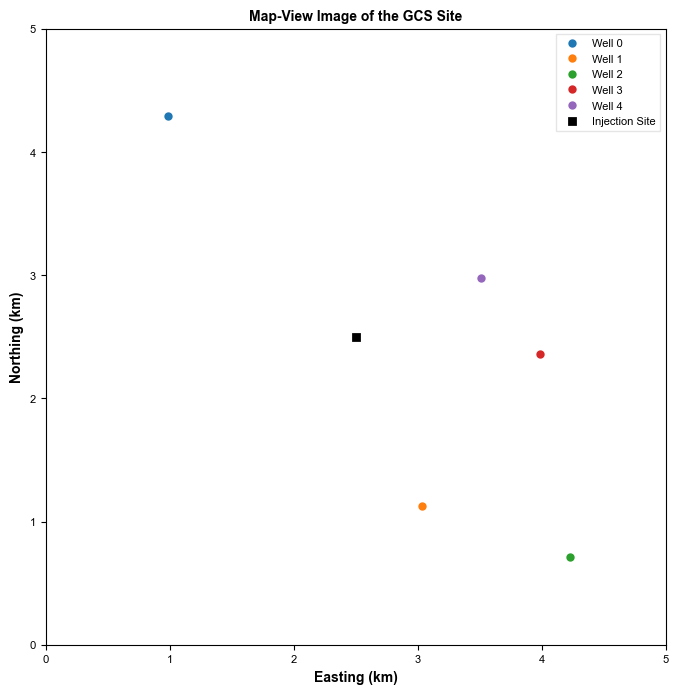

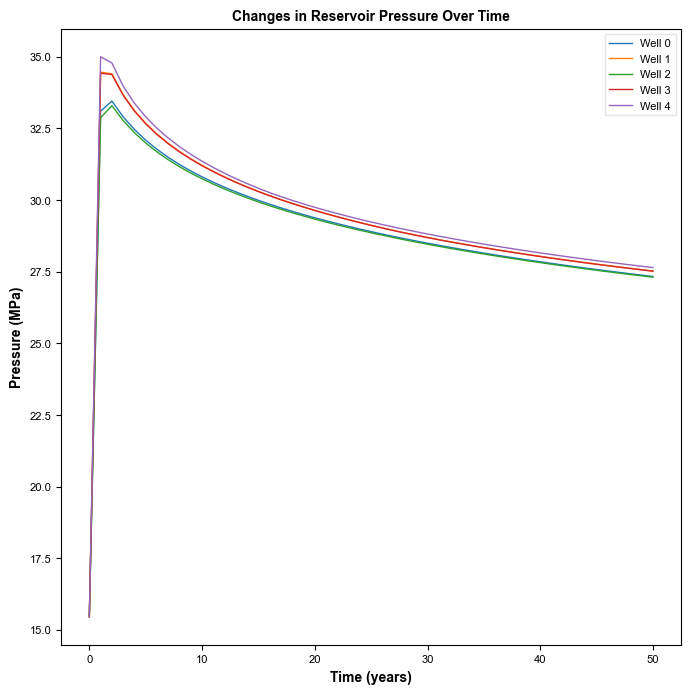

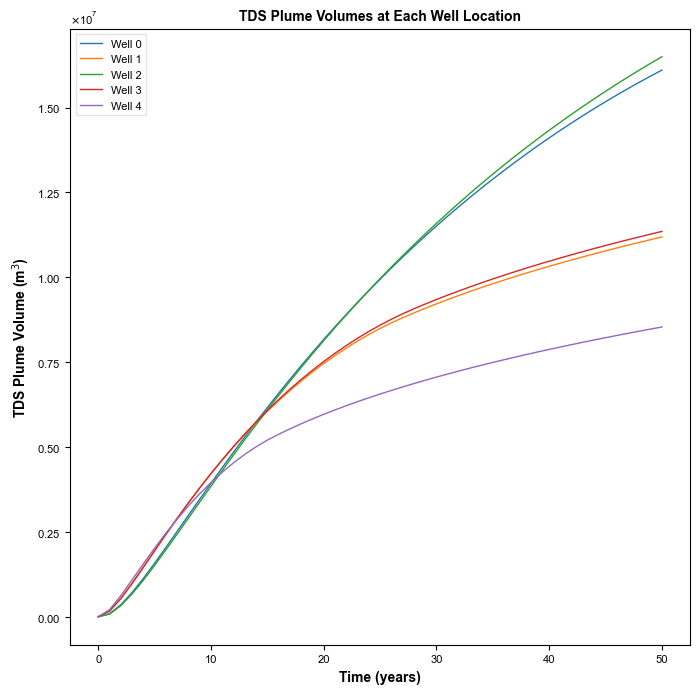

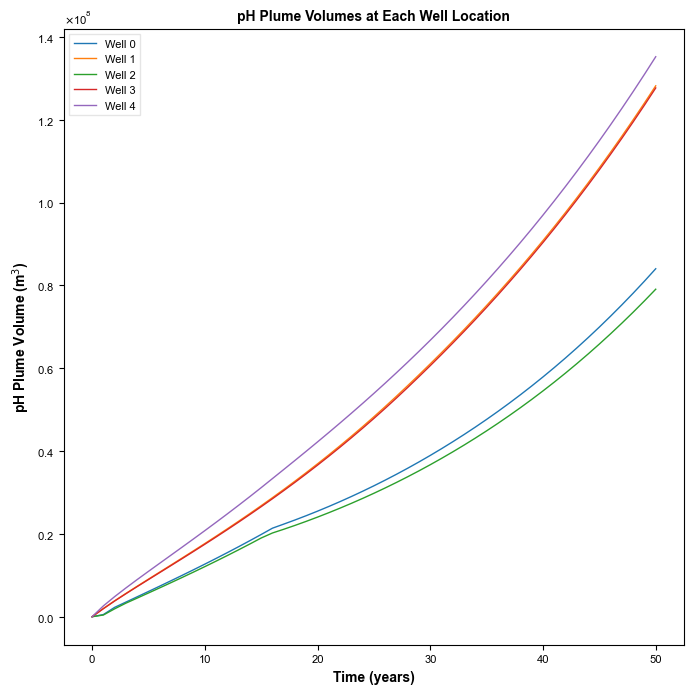

In [8]:
# Run system model using current values of its parameters
sm.forward()  # system model is run deterministically

# Change the formatting of figures
plt.rc('font', **RC_FONT)

for locRef in range(numberOfWells):
    fig0 = plt.figure(0, figsize=figsize1, dpi=dpiRef)
    ax = plt.gca()
    
    ax.plot(well_x_values[locRef] / 1000, well_y_values[locRef] / 1000, linestyle='none',
            marker='o', markeredgewidth=2, markersize=4, label='Well {}'.format(locRef))
    
    fig1 = plt.figure(1, figsize=figsize1, dpi=dpiRef)
    ax = plt.gca()
    
    pressure_Pa = sm.collect_observations_as_time_series(ares[locRef], 'pressure')
    ax.plot(time_array / 365.25, pressure_Pa / 1.0e+6, label='Well {}'.format(locRef), linewidth=1)
    
    fig2 = plt.figure(2, figsize=figsize1, dpi=dpiRef)
    ax = plt.gca()
    
    TDS_volume_m3 = sm.collect_observations_as_time_series(fgaq[locRef], 'TDS_volume')
    ax.plot(time_array / 365.25, TDS_volume_m3, label='Well {}'.format(locRef), linewidth=1)
    
    fig3 = plt.figure(3, figsize=figsize1, dpi=dpiRef)
    ax = plt.gca()
    
    pH_volume_m3 = sm.collect_observations_as_time_series(fgaq[locRef], 'pH_volume')
    ax.plot(time_array / 365.25, pH_volume_m3, label='Well {}'.format(locRef), linewidth=1)

fig0 = plt.figure(0, figsize=figsize1, dpi=dpiRef)
ax = plt.gca()

ax.plot(injectionX / 1000, injectionY / 1000, color='k', linestyle='none',
        marker='s', markeredgewidth=2, markersize=4, label='Injection Site')

plt.xlabel('Easting (km)', fontsize=axislabelfontsize, fontweight='bold')
plt.ylabel('Northing (km)', fontsize=axislabelfontsize, fontweight='bold')

plt.title('Map-View Image of the GCS Site', fontsize=titlefontsize, fontweight='bold')

plt.legend(fancybox=False, fontsize=genfontsize, framealpha=0.5)

plt.xlim([0, max_x_value / 1000])
plt.ylim([0, max_y_value / 1000])

fig1 = plt.figure(1, figsize=figsize1, dpi=dpiRef)

plt.xlabel('Time (years)', fontsize=axislabelfontsize, fontweight='bold')
plt.ylabel('Pressure (MPa)', fontsize=axislabelfontsize, fontweight='bold')

plt.title('Changes in Reservoir Pressure Over Time', fontsize=titlefontsize, fontweight='bold')

plt.legend(fancybox=False, fontsize=genfontsize, framealpha=0.5)

fig2 = plt.figure(2, figsize=figsize1, dpi=dpiRef)

plt.xlabel('Time (years)', fontsize=axislabelfontsize, fontweight='bold')
plt.ylabel('TDS Plume Volume (m$^3$)', fontsize=axislabelfontsize, fontweight='bold')

# Make the axis use scientific notation
plt.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0), useMathText = True)

plt.title('TDS Plume Volumes at Each Well Location', fontsize=titlefontsize, fontweight='bold')

plt.legend(fancybox=False, fontsize=genfontsize, framealpha=0.5)

fig3 = plt.figure(3, figsize=figsize1, dpi=dpiRef)

plt.xlabel('Time (years)', fontsize=axislabelfontsize, fontweight='bold')
plt.ylabel('pH Plume Volume (m$^3$)', fontsize=axislabelfontsize, fontweight='bold')

# Make the axis use scientific notation
plt.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0), useMathText = True)

plt.title('pH Plume Volumes at Each Well Location', fontsize=titlefontsize, fontweight='bold')

plt.legend(fancybox=False, fontsize=genfontsize, framealpha=0.5)

plt.show()

Now, run the TTFD plot type. Before proceeding, wait for the code to print 'Finished'.

In [9]:
if not os.path.exists(model_data['OutputDirectory']):
    os.mkdir(model_data['OutputDirectory'])

analysis = 'forward'
s = None

print('Running TTFD plot type...')

iam_vis.ttfd_plot(yaml_data, model_data, sm, s, model_data['OutputDirectory'],
                  name=plotName, analysis=analysis)

print('Finished.')

Running TTFD plot type...
Finished.


Once the code above has finished, the code below can be used to load the figures saved by the TTFD plot type. The plume timing figure divides the depth range of the simulation's stratigraphy into four subplots, with each subplot showing a quarter of the range. The depth range containing the plumes will depend on the stratigraphy and the aquifer being assessed, which is controlled through the aqRef variable. Note that the figure says 'Layers with Lower Times Shown Above Other Layers' because there are different layers of results for different depth intervals. Each subplot shows the results for multiple depth intervals, but depth intervals that have earlier times will be shown on top of other layers. All plume timings are saved in .csv files, if yaml_data['Plots'][plotName]['TTFD']['SaveCSVFiles'] is set to True further above.

If no monitoring locations are provided further above (monitor_coordx, monitor_coordy, and monitor_coordz - use_specific_settings has to be set to True), then the code will print a statement saying that the 'TDS_Monitoring_TTFD' figure cannot be found.

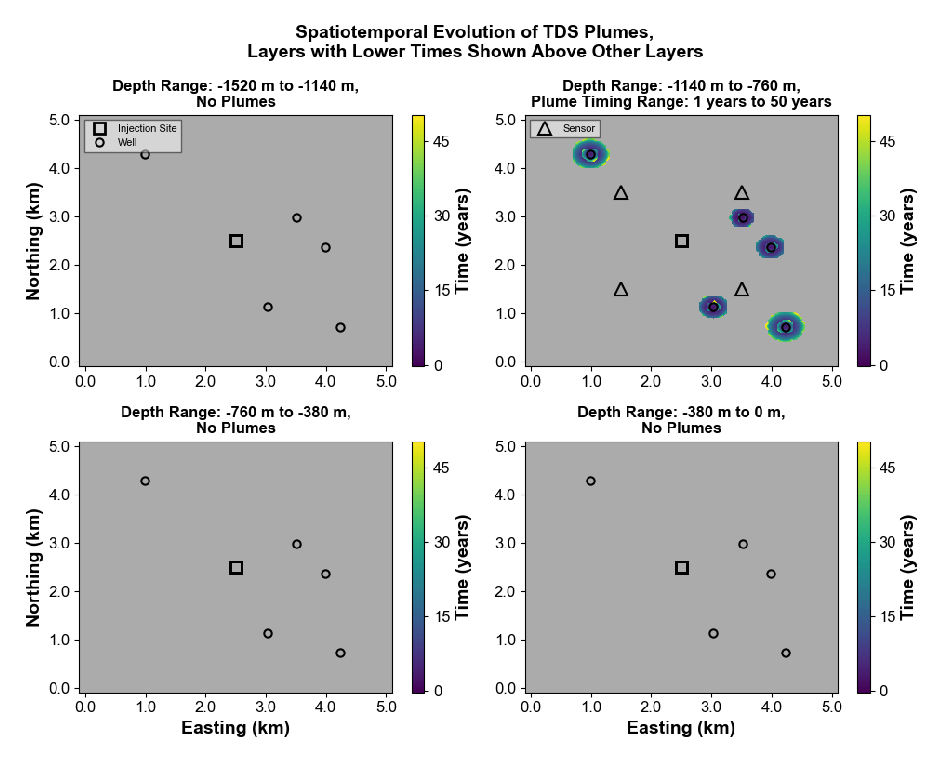

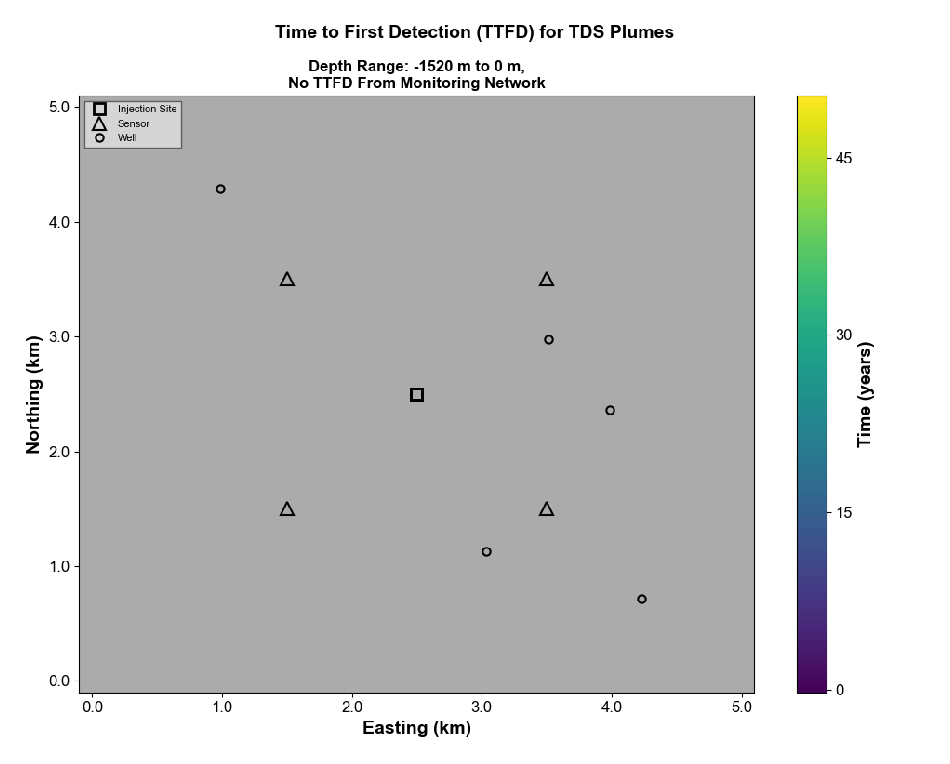

In [10]:
figure_names = ['TDS_Plume_Timings' + extension, 'TDS_Monitoring_TTFD' + extension]

# Change the formatting of figures
plt.rc('font', **RC_FONT)

for figRef in range(len(figure_names)):
    file_path = os.path.join(model_data['OutputDirectory'], figure_names[figRef])
    
    check_for_figure = os.path.exists(file_path)
    
    if check_for_figure:
        img = mpimg.imread(file_path)
        
        fig = plt.figure(figRef + 4, figsize=figsize2, dpi=dpiRef)
        ax = plt.gca()
    
        ax.imshow(img, interpolation='nearest')
    
        # We do not need the ticks from imshow, the figure file has its own ticks
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

        # We also do not need the spline added by imshow
        plt.setp(ax.spines.values(), alpha = 0)
        
        plt.show()
    else:
        print('The figure {} was not found.'.format(file_path))

Because the well locations are randomly generated, the TTFD plots will be different if you rerun all of the code in this Jupyter Notebook example. You can rerun everything using from by choosing 'Restart & Run All' from 'Kernel' in the menu bar along the top of the screen. If you do so, the ttfd_plot() function above will take a moment to finish running.

The plots will also be different if you change the aqRef variable, which controls whether the TTFD analysis focuses on aquifer 1 (aqRef = 0) or aquifer 2 (aqRef = 1). Additionally, you can change the number of leaking wells (the numberOfWells variable), the depths of the sensor equipment along the monitoring wells (monitor_coordz), or the vertical extent of the sensors along each monitoring well (vertical_window).

This example uses an AnalyticalReservoir component because it runs quickly and the purpose of this example is to demonstrate the concepts behind the TTFD plot type. The TTFD analyses made for a GCS site should use a LookupTableReservoir to incorporate results from high-fidelity reservoir simulations. Additionally, the locations and properties of legacy wells and other potential leakage pathways could be constrained and used in the parameterization of the leakage pathway components.